In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Data/EEG/')

# Package Importing

In [ ]:
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
from keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#EDA - Exploratory data analysis

### Data Loading

In [ ]:
X_train_valid = np.load("/content/drive/MyDrive/Colab Notebooks/Data/EEG/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/Colab Notebooks/Data/EEG/y_train_valid.npy")
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/Data/EEG/X_test.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/Data/EEG/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/Colab Notebooks/Data/EEG/person_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/Colab Notebooks/Data/EEG/person_test.npy")

print (f'Training/Valid data shape: {X_train_valid.shape}')
print (f'Training/Valid target shape: {y_train_valid.shape}')
print (f'Test data shape: {X_test.shape}')
print (f'Test target shape: {y_test.shape}')
print (f'Person train/valid shape: {person_train_valid.shape}')
print (f'Person test shape: {person_test.shape}')

Training/Valid data shape: (2115, 22, 1000)
Training/Valid target shape: (2115,)
Test data shape: (443, 22, 1000)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Data Visulazation

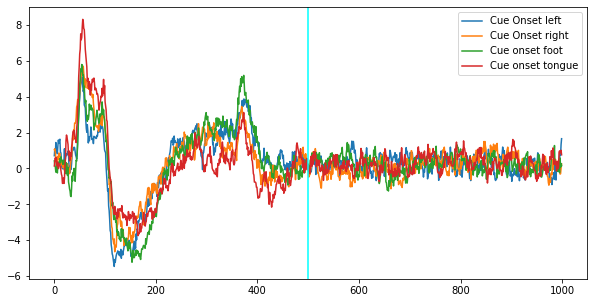

In [ ]:
# Assign labels to the data
# re-assign labels to be between 0 and 3
y_train_valid[y_train_valid==769] = 0  # cue onset left
y_train_valid[y_train_valid==770] = 1  # cue onset right
y_train_valid[y_train_valid==771] = 2  # cue onset foot
y_train_valid[y_train_valid==772] = 3  # cue onset tongue

y_test[y_test==769] = 0  # cue onset left
y_test[y_test==770] = 1  # cue onset right
y_test[y_test==771] = 2  # cue onset foot
y_test[y_test==772] = 3  # cue onset tongue

ch_data = X_train_valid[:,5,:] # extracts the 6th channel from the data

class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 6th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.figure(figsize=(10, 5))
plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

## Data Augmentation and Data Splitting

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (2115,22,1000) -> (2115,22,500)
    X = X[:,:,0:500]
    
    # Maxpooling the data (2115,22,500) -> (2115,22,500/(sub_sample=2))
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
        
    # Averaging + noise, size (2115,22,500) -> (2115,22,500/(average=2))
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((X_max, X_average))
    total_y = np.hstack((y, y))
    
    # Subsampling    
    for i in range(sub_sample):        
        X_subsample = X[:, :, i::sub_sample] + \
                  (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
            
    return total_X,total_y

In [ ]:
# split the training and validation
# Creating the training and validation sets using the generated indices
np.random.seed(12345)
ind_valid = np.random.choice(2115, 323, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(X_train_split, X_valid_split) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train_split, y_valid_split) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Preprocessing the dataset
X_train_prep, y_train_prep = data_prep(X_train_split,y_train_split,2,2,True)
X_valid_prep, y_valid_prep = data_prep(X_valid_split,y_valid_split,2,2,True)
X_test_prep, y_test_prep = data_prep(X_test,y_test,2,2,True)


print(f'Training data shape after Preprocessing: {X_train_prep.shape}')
print(f'Training target shape after Preprocessing: {y_train_prep.shape}')

print(f'Valid data shape after Preprocessing: {X_valid_prep.shape}')
print(f'Valid target shape after Preprocessing: {y_valid_prep.shape}')

print(f'Testing data shape after Preprocessing: {X_test_prep.shape}')
print(f'Testing target shape after Preprocessing: {y_test_prep.shape}')

Training data shape after Preprocessing: (7168, 22, 250)
Training target shape after Preprocessing: (7168,)
Valid data shape after Preprocessing: (1292, 22, 250)
Valid target shape after Preprocessing: (1292,)
Testing data shape after Preprocessing: (1772, 22, 250)
Testing target shape after Preprocessing: (1772,)


## Data Preprocessing 

In [ ]:
# Converting the labels to categorical variables for multiclass classification
y_train_ready = to_categorical(y_train_prep, 4)
y_valid_ready = to_categorical(y_valid_prep, 4)
y_test_ready = to_categorical(y_test_prep, 4)
print('Training target shape after categorical conversion:',y_train_ready.shape)
print('Valid target shape after categorical conversion:',y_valid_ready.shape)
print('Testing target shape after categorical conversion:',y_test_ready.shape)

Training target shape after categorical conversion: (7168, 4)
Valid target shape after categorical conversion: (1292, 4)
Testing target shape after categorical conversion: (1772, 4)


In [ ]:
# add extra dimension for grayscale images
X_train_grayscale = np.expand_dims(X_train_prep, axis=-1)
X_valid_grayscale = np.expand_dims(X_valid_prep, axis=-1)
X_test_grayscale = np.expand_dims(X_test_prep, axis=-1)

print(f'Training data shape for grayscale images: {X_train_grayscale.shape}')
print(f'Validation data shape for grayscale images: {X_valid_grayscale.shape}')
print(f'Testing data shape for grayscale images: {X_test_grayscale.shape}')

# rearange input dimensions
# model expects (batch, seq, features(channels)) but currently we have (batch, features(channels), seq)
X_train_transpose = np.transpose(X_train_grayscale, (0, 2, 3, 1))
X_valid_transpose = np.transpose(X_valid_grayscale, (0, 2, 3, 1))
X_test_transpose = np.transpose(X_test_grayscale, (0, 2, 3, 1))

print(f"Training data shape after rearange: {X_train_transpose.shape}")
print(f"Valid data shape after rearange: {X_valid_transpose.shape}")
print(f"Testing data shape after rearange: {X_test_transpose.shape}")

# construct the dataset from the NumPy arrays
X_y_t = tf.data.Dataset.from_tensor_slices((X_train_transpose, y_train_ready))
X_y_v = tf.data.Dataset.from_tensor_slices((X_valid_transpose, y_valid_ready))
X_y_te = tf.data.Dataset.from_tensor_slices((X_test_transpose, y_test_ready))

Training data shape for grayscale images: (7168, 22, 250, 1)
Validation data shape for grayscale images: (1292, 22, 250, 1)
Testing data shape for grayscale images: (1772, 22, 250, 1)
Training data shape after rearange: (7168, 250, 1, 22)
Valid data shape after rearange: (1292, 250, 1, 22)
Testing data shape after rearange: (1772, 250, 1, 22)


In [ ]:
# batch and shuffle
X_y_train = X_y_t.shuffle(1024).batch(128)
X_y_valid = X_y_v.shuffle(1024).batch(128)
X_y_test = X_y_te.shuffle(1024).batch(128)

# Building the model - CNN Architecture

In [ ]:
# Building the CNN model using sequential class
basic_cnn_model = keras.Sequential()

# Conv. block 1
basic_cnn_model.add(keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', 
                    input_shape=(250,1,22), kernel_regularizer=regularizers.l2(0.05), name='conv1'))
basic_cnn_model.add(keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(keras.layers.BatchNormalization())
basic_cnn_model.add(keras.layers.Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu',
                    kernel_regularizer=regularizers.l2(0.03), name='conv2'))
basic_cnn_model.add(keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(keras.layers.BatchNormalization())
basic_cnn_model.add(keras.layers.Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu',
                    kernel_regularizer=regularizers.l2(0.01), name='conv3'))
basic_cnn_model.add(keras.layers.AveragePooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(keras.layers.BatchNormalization())
basic_cnn_model.add(keras.layers.Dropout(0.3))

# Conv. block 4
basic_cnn_model.add(keras.layers.Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu',
                    kernel_regularizer=regularizers.l2(0.01), name='conv4'))
basic_cnn_model.add(keras.layers.AveragePooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(keras.layers.BatchNormalization())
basic_cnn_model.add(keras.layers.Dropout(0.3))

# Output layer with Softmax activation
basic_cnn_model.add(keras.layers.Flatten()) # Flattens the input
basic_cnn_model.add(keras.layers.Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2 (Conv2D)              (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

# Model Training and Evaluation

In [ ]:
# Chose Adam as optimizer with annealing learning rate
opt = keras.optimizers.Adam(learning_rate=0.001, use_ema = True, ema_momentum=0.9)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)

# Computes the crossentropy loss between the labels and predictions.
loss_fn = keras.losses.CategoricalCrossentropy()

# Compiling the model
basic_cnn_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x=X_y_train, validation_data=X_y_valid,
                epochs=50, callbacks=[lr_callback], verbose=True)

Epoch 1/50
56/56 [==============================] - 14s 19ms/step - loss: 5.6247 - accuracy: 0.3574 - val_loss: 5.2294 - val_accuracy: 0.3901 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 1s 13ms/step - loss: 4.3294 - accuracy: 0.4534 - val_loss: 3.7358 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 1s 12ms/step - loss: 3.3943 - accuracy: 0.5257 - val_loss: 3.0794 - val_accuracy: 0.5255 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 1s 17ms/step - loss: 2.6639 - accuracy: 0.5826 - val_loss: 2.4583 - val_accuracy: 0.5580 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 1s 17ms/step - loss: 2.1643 - accuracy: 0.6161 - val_loss: 2.2751 - val_accuracy: 0.4420 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - 1s 13ms/step - loss: 1.8012 - accuracy: 0.6487 - val_loss: 1.9297 - val_accuracy: 0.5209 - lr: 0.0010
Epoch 7/50
56/56 [==============================] - 1s 12ms/step - loss: 1.

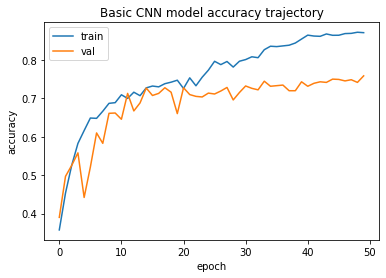

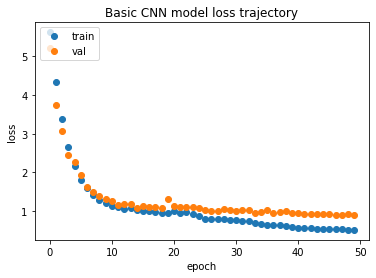

In [ ]:
# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test set Predictions

In [ ]:
import time
start_time = time.time() 

# Testing the basic CNN model
cnn_score = basic_cnn_model.evaluate(x=X_y_test, verbose=0)

end_time = time.time()
total_time = end_time - start_time
print('Test accuracy of the basic CNN model:',cnn_score[1])

print("Total running time: {:.2f} seconds".format(total_time))

Test accuracy of the basic CNN model: 0.7336342930793762
Total running time: 0.26 seconds


# Accuracy score for special subjects

In [ ]:
def preson_data_prep(person):
    
    total_person = None

    total_person = np.vstack((person, person, person, person))
    
    return total_person

person_test_prep = preson_data_prep(person_test)

print(f'Testing target shape after Preprocessing: {person_test_prep.shape}')

Testing target shape after Preprocessing: (1772, 1)


In [ ]:
idx_sub1 = np.where(person_test_prep==0)[0]
idx_sub2 = np.where(person_test_prep==1)[0]
idx_sub3 = np.where(person_test_prep==2)[0]
idx_sub4 = np.where(person_test_prep==3)[0]
idx_sub5 = np.where(person_test_prep==4)[0]
idx_sub6 = np.where(person_test_prep==5)[0]
idx_sub7 = np.where(person_test_prep==6)[0]
idx_sub8 = np.where(person_test_prep==7)[0]
idx_sub9 = np.where(person_test_prep==8)[0]

In [ ]:
print('Optimizing for all subjects:')
print('Subject 1:')
sub1 = basic_cnn_model.evaluate(X_test_transpose[idx_sub1], y_test_ready[idx_sub1], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 1: {sub1[1]}')
print('Subject 2:')
sub2 = basic_cnn_model.evaluate(X_test_transpose[idx_sub2], y_test_ready[idx_sub2], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 2: {sub2[1]}')
print('Subject 3:')
sub3= basic_cnn_model.evaluate(X_test_transpose[idx_sub3], y_test_ready[idx_sub3], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 3: {sub3[1]}')
print('Subject 4:')
sub4= basic_cnn_model.evaluate(X_test_transpose[idx_sub4], y_test_ready[idx_sub4], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 4: {sub4[1]}')
print('Subject 5:')
sub5 = basic_cnn_model.evaluate(X_test_transpose[idx_sub5], y_test_ready[idx_sub5], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 5: {sub5[1]}')
print('Subject 6:')
sub6 = basic_cnn_model.evaluate(X_test_transpose[idx_sub6], y_test_ready[idx_sub6], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 6: {sub6[1]}')
print('Subject 7:')
sub7 = basic_cnn_model.evaluate(X_test_transpose[idx_sub7], y_test_ready[idx_sub7], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 7: {sub7[1]}')
print('Subject 8:')
sub8 = basic_cnn_model.evaluate(X_test_transpose[idx_sub8], y_test_ready[idx_sub8], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 8: {sub8[1]}')
print('Subject 9:')
sub9 = basic_cnn_model.evaluate(X_test_transpose[idx_sub9], y_test_ready[idx_sub9], verbose=0)
print(f'Test accuracy of the basic CNN model on subject 9: {sub9[1]}')

Optimizing for all subjects:
Subject 1:
Test accuracy of the basic CNN model on subject 1: 0.7699999809265137
Subject 2:
Test accuracy of the basic CNN model on subject 2: 0.5600000023841858
Subject 3:
Test accuracy of the basic CNN model on subject 3: 0.7699999809265137
Subject 4:
Test accuracy of the basic CNN model on subject 4: 0.75
Subject 5:
Test accuracy of the basic CNN model on subject 5: 0.7872340679168701
Subject 6:
Test accuracy of the basic CNN model on subject 6: 0.7142857313156128
Subject 7:
Test accuracy of the basic CNN model on subject 7: 0.7549999952316284
Subject 8:
Test accuracy of the basic CNN model on subject 8: 0.7549999952316284
Subject 9:
Test accuracy of the basic CNN model on subject 9: 0.7446808218955994


Optimizing for all subjects:


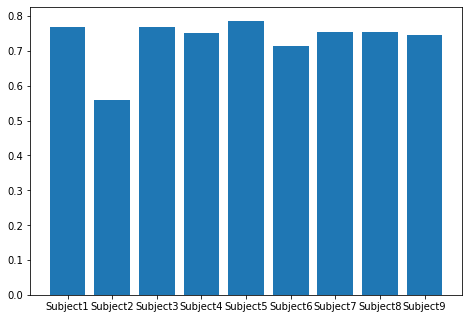

In [ ]:
subject_labels = ['Subject1','Subject2','Subject3','Subject4','Subject5','Subject6','Subject7','Subject8','Subject9',]
all_optimization_accuracies = [sub1[1],sub2[1],sub3[1],sub4[1],sub5[1],sub6[1],sub7[1],sub8[1],sub9[1]]

ax = plt.figure().add_axes([0,0,1,1])
print('Optimizing for all subjects:')
ax.bar(subject_labels,all_optimization_accuracies)
plt.show()